In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
import numpy as np
from equation_as2 import equation

In [2]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
#import dataset
train_x = pickle.load(open('./Data/train_pairs.pickle','rb'))
train_y = pickle.load(open('./Data/train_y.pickle','rb'))
test_x1 = pickle.load(open('./Data/test_pairs1.pickle','rb'))
test_y1 = pickle.load(open('./Data/test_y1.pickle','rb'))
test_x2 = pickle.load(open('./Data/test_pairs2.pickle','rb'))
test_y2 = pickle.load(open('./Data/test_y2.pickle','rb'))
test_x3 = pickle.load(open('./Data/test_pairs3.pickle','rb'))
test_y3 = pickle.load(open('./Data/test_y3.pickle','rb'))

In [4]:
train_x = train_x.astype('float32')
test_x1 = test_x1.astype('float32')
test_x2 = test_x2.astype('float32')
test_x3 = test_x3.astype('float32')
train_x /= 255
test_x1 /= 255
test_x2 /= 255
test_x3 /= 255

### Define margin

In [5]:
Ass2_Equation = equation(0.7)

In [6]:
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0],2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0],2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0],2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [7]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation='relu',name = 'embeding')(x) 
    
    return Model(input_tensor, output)

In [8]:
def create_base_network_1(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu',name = 'embeding')(x) 
    output = Dense(128, activation='relu',name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [9]:
def siamese_model(input_shape,cnn_base_network):
    base_network = cnn_base_network
    base_network.summary()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(equation.euclidean_distance,
                      output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    model.summary()
    
    return model

In [10]:
def plot_loss_accuracy(history,parameter):
    print("Tuning :"+parameter)
    loss = history.history['loss'].copy()
    val_loss= history.history['val_loss'].copy()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss','Validation loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    accuracy = history.history['accuracy'].copy()
    val_accuracy = history.history['val_accuracy'].copy()
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [11]:
def evaluate_test_accuracy(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = equation.compute_accuracy(test_y1, pred1)
    te_acc2 = equation.compute_accuracy(test_y2, pred2)
    te_acc3 = equation.compute_accuracy(test_y3, pred3)
    print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
    print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
    print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

    model.save('./Data/model'+model_name+'.h5')

### Tuning Hyperparameters

In [45]:
#check full connect embedding 1

In [46]:
select_base_arch=create_base_network(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [14]:
model_name='lr_1e-4_emb_1'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

W1006 16:15:47.470170  9892 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 143us/sample - loss: 3.5262 - accuracy: 0.5040 - val_loss: 0.2830 - val_accuracy: 0.4537
Epoch 2/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.2002 - accuracy: 0.5158 - val_loss: 0.2144 - val_accuracy: 0.5113
Epoch 3/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.1691 - accuracy: 0.5760 - val_loss: 0.1960 - val_accuracy: 0.5417
Epoch 4/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.1350 - accuracy: 0.6714 - val_loss: 0.1932 - val_accuracy: 0.6511
Epoch 5/200
60145/60145 [==============================] - 7s 109us/sample - loss: 0.1042 - accuracy: 0.7481 - val_loss: 0.1353 - val_accuracy: 0.8003
Epoch 6/200
60145/60145 [==============================] - 7s 108us/sample - loss: 0.0824 - accuracy: 0.8022 - val_loss: 0.0870 - val_accuracy: 0.8422
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4_emb_1


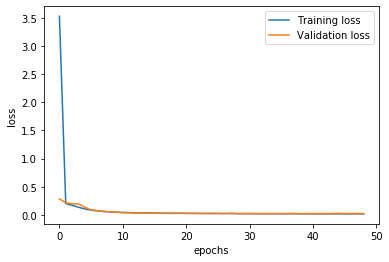

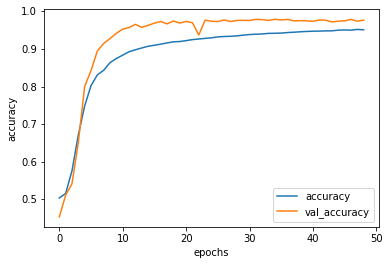

Tuning :lr_1e-4_emb_1
* Accuracy on test1 set: 93.25%
* Accuracy on test2 set: 68.06%
* Accuracy on test3 set: 81.05%


In [15]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [47]:
select_base_arch=create_base_network_1(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [48]:
model_name='lr_1e-4_emb_2'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 134us/sample - loss: 1.9414 - accuracy: 0.5255 - val_loss: 0.2145 - val_accuracy: 0.5379
Epoch 2/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1359 - accuracy: 0.6373 - val_loss: 0.1544 - val_accuracy: 0.6503
Epoch 3/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0908 - accuracy: 0.7505 - val_loss: 0.1058 - val_accuracy: 0.8083
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0681 - accuracy: 0.8043 - val_loss: 0.0559 - val_accuracy: 0.8918
Epoch 5/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0509 - accuracy: 0.8390 - val_loss: 0.0387 - val_accuracy: 0.9137
Epoch 6/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0441 - accuracy: 0.8580 - val_loss: 0.0323 - val_accuracy: 0.9277
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4_emb_2


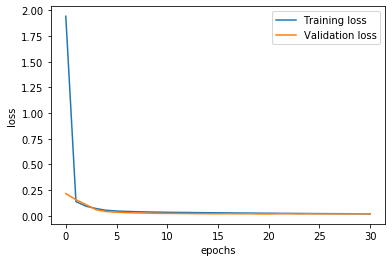

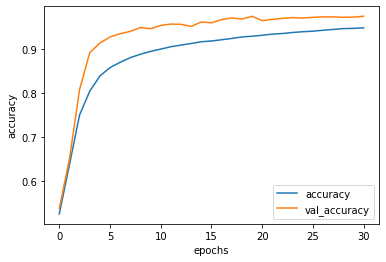

Tuning :lr_1e-4_emb_2
* Accuracy on test1 set: 93.63%
* Accuracy on test2 set: 70.76%
* Accuracy on test3 set: 81.81%


In [49]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Learning rate

In [19]:
select_base_arch=create_base_network_1(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [20]:
model_name='lr_1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 127us/sample - loss: 1.8959 - accuracy: 0.5357 - val_loss: 0.1252 - val_accuracy: 0.6377
Epoch 2/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.1146 - accuracy: 0.6790 - val_loss: 0.0674 - val_accuracy: 0.8581
Epoch 3/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0655 - accuracy: 0.8032 - val_loss: 0.0502 - val_accuracy: 0.8924
Epoch 4/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0491 - accuracy: 0.8568 - val_loss: 0.0442 - val_accuracy: 0.9223
Epoch 5/200
60145/60145 [==============================] - 7s 115us/sample - loss: 0.0418 - accuracy: 0.8841 - val_loss: 0.0360 - val_accuracy: 0.9334
Epoch 6/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0368 - accuracy: 0.9008 - val_loss: 0.0330 - val_accuracy: 0.9419
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4


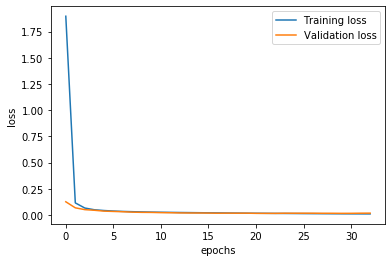

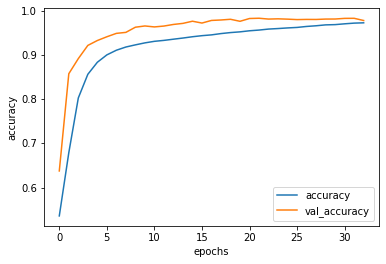

Tuning :lr_1e-4
* Accuracy on test1 set: 95.49%
* Accuracy on test2 set: 69.99%
* Accuracy on test3 set: 82.92%


In [21]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [23]:
select_base_arch=create_base_network_1(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [24]:
model_name='lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.2420 - accuracy: 0.8244 - val_loss: 0.0267 - val_accuracy: 0.9493
Epoch 2/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0286 - accuracy: 0.9242 - val_loss: 0.0186 - val_accuracy: 0.9779
Epoch 3/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0239 - accuracy: 0.9336 - val_loss: 0.0185 - val_accuracy: 0.9766
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0211 - accuracy: 0.9400 - val_loss: 0.0181 - val_accuracy: 0.9769
Epoch 5/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0189 - accuracy: 0.9446 - val_loss: 0.0127 - val_accuracy: 0.9795
Epoch 6/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0167 - accuracy: 0.9508 - val_loss: 0.0147 - val_accuracy: 0.9832
Epoch 7/200
60145/60145 [====================

Tuning :lr1e-3


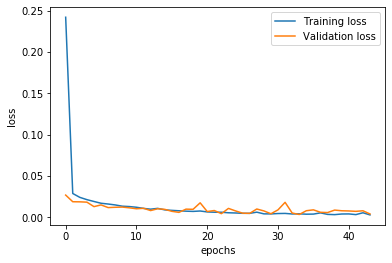

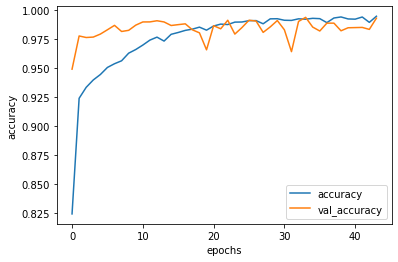

In [25]:
plot_loss_accuracy(history, model_name)

In [26]:
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :lr1e-3
* Accuracy on test1 set: 96.09%
* Accuracy on test2 set: 62.87%
* Accuracy on test3 set: 80.54%


In [27]:
select_base_arch=create_base_network_1(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [28]:
model_name='lr3e-3'
# train
epochs = 200
adam = Adam(learning_rate=3e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.1716 - accuracy: 0.8262 - val_loss: 0.0326 - val_accuracy: 0.9459
Epoch 2/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0355 - accuracy: 0.8874 - val_loss: 0.0272 - val_accuracy: 0.9579
Epoch 3/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0314 - accuracy: 0.9018 - val_loss: 0.0228 - val_accuracy: 0.9590
Epoch 4/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0286 - accuracy: 0.9103 - val_loss: 0.0202 - val_accuracy: 0.9688
Epoch 5/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0270 - accuracy: 0.9151 - val_loss: 0.0192 - val_accuracy: 0.9429
Epoch 6/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0254 - accuracy: 0.9202 - val_loss: 0.0202 - val_accuracy: 0.9714
Epoch 7/200
60145/60145 [====================

Tuning :lr3e-3


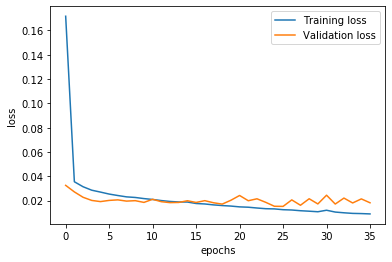

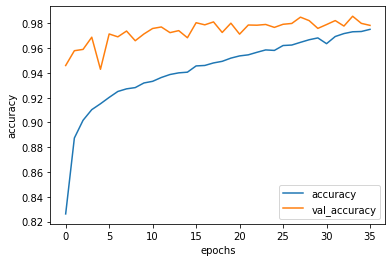

Tuning :lr3e-3
* Accuracy on test1 set: 93.69%
* Accuracy on test2 set: 70.18%
* Accuracy on test3 set: 82.15%


In [29]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [30]:
select_base_arch=create_base_network_1(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [31]:
model_name='lr1e+3'
# train
epochs = 200
adam = Adam(learning_rate=1e+3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 134us/sample - loss: 42677441118708867072.0000 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.5002
Epoch 2/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.5002
Epoch 3/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.5008
Epoch 4/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.5002
Epoch 5/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4997
Epoch 6/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4985
Epoch 7/200
60145/60145 [=

Tuning :lr1e+3


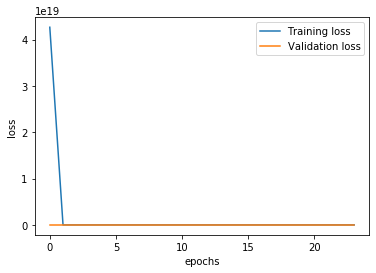

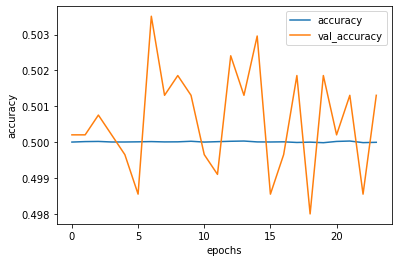

Tuning :lr1e+3
* Accuracy on test1 set: 50.00%
* Accuracy on test2 set: 50.00%
* Accuracy on test3 set: 50.00%


In [32]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

leaky_RELU

In [12]:
def create_base_network_leaky_relu(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [13]:
select_base_arch=create_base_network_leaky_relu(input_shape)
model=siamese_model(input_shape,select_base_arch)

W1007 06:59:00.025432 14436 deprecation.py:506] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          18496 

In [14]:
model_name='leaky_relu_lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

W1007 06:59:04.559816 14436 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 10s 172us/sample - loss: 1.8981 - accuracy: 0.5798 - val_loss: 0.1487 - val_accuracy: 0.6983
Epoch 2/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.1063 - accuracy: 0.7501 - val_loss: 0.0825 - val_accuracy: 0.8883
Epoch 3/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0770 - accuracy: 0.8057 - val_loss: 0.0610 - val_accuracy: 0.8971
Epoch 4/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.0649 - accuracy: 0.8309 - val_loss: 0.0529 - val_accuracy: 0.9007
Epoch 5/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.0578 - accuracy: 0.8535 - val_loss: 0.0458 - val_accuracy: 0.9089
Epoch 6/200
60145/60145 [==============================] - 7s 122us/sample - loss: 0.0521 - accuracy: 0.8693 - val_loss: 0.0414 - val_accuracy: 0.9285
Epoch 7/200
60145/60145 [===================

Tuning :leaky_relu_lr1e-4


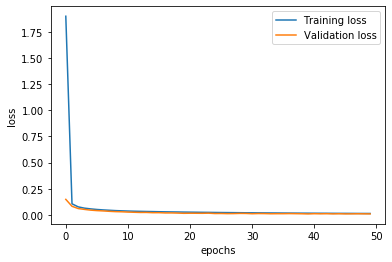

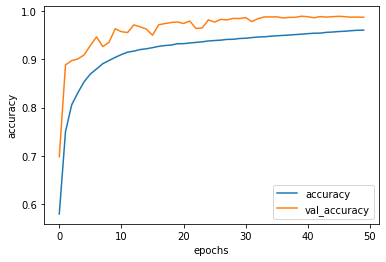

Tuning :leaky_relu_lr1e-4
* Accuracy on test1 set: 95.45%
* Accuracy on test2 set: 69.08%
* Accuracy on test3 set: 82.60%


In [15]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [16]:
select_base_arch=create_base_network_leaky_relu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [17]:
model_name='leaky_relu_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 135us/sample - loss: 0.3004 - accuracy: 0.8134 - val_loss: 0.0380 - val_accuracy: 0.9266
Epoch 2/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0437 - accuracy: 0.8906 - val_loss: 0.0316 - val_accuracy: 0.9476
Epoch 3/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0370 - accuracy: 0.9077 - val_loss: 0.0261 - val_accuracy: 0.9685
Epoch 4/200
60145/60145 [==============================] - 8s 126us/sample - loss: 0.0334 - accuracy: 0.9162 - val_loss: 0.0231 - val_accuracy: 0.9595
Epoch 5/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0312 - accuracy: 0.9214 - val_loss: 0.0188 - val_accuracy: 0.9710
Epoch 6/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0290 - accuracy: 0.9256 - val_loss: 0.0199 - val_accuracy: 0.9723
Epoch 7/200
60145/60145 [====================

60145/60145 [==============================] - 8s 127us/sample - loss: 0.0048 - accuracy: 0.9946 - val_loss: 0.0079 - val_accuracy: 0.9915
Epoch 55/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0047 - accuracy: 0.9949 - val_loss: 0.0064 - val_accuracy: 0.9934
Epoch 56/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0047 - accuracy: 0.9947 - val_loss: 0.0084 - val_accuracy: 0.9902
Epoch 57/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0044 - accuracy: 0.9955 - val_loss: 0.0124 - val_accuracy: 0.9865
Epoch 58/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0046 - accuracy: 0.9949 - val_loss: 0.0081 - val_accuracy: 0.9906oss:
Epoch 59/200
60145/60145 [==============================] - 8s 129us/sample - loss: 0.0043 - accuracy: 0.9954 - val_loss: 0.0098 - val_accuracy: 0.9894
Epoch 60/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0043 - accu

Tuning :leaky_relu_lr1e-3


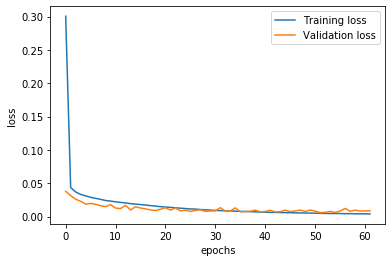

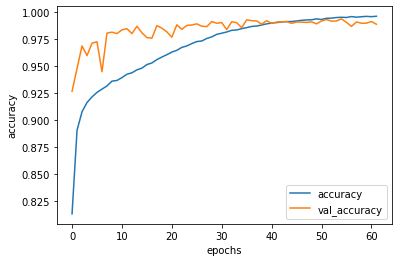

Tuning :leaky_relu_lr1e-3
* Accuracy on test1 set: 96.56%
* Accuracy on test2 set: 67.92%
* Accuracy on test3 set: 82.77%


In [18]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [14]:
##drop out

In [15]:
def create_base_network_drop(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [16]:
select_base_arch=create_base_network_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [17]:
model_name='leaky_relu_lr1e-4_dropout'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

W1006 23:36:21.614561 15144 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 10s 175us/sample - loss: 3.7574 - accuracy: 0.5005 - val_loss: 0.1149 - val_accuracy: 0.7147
Epoch 2/200
60145/60145 [==============================] - 8s 126us/sample - loss: 0.2648 - accuracy: 0.5249 - val_loss: 0.0997 - val_accuracy: 0.5622
Epoch 3/200
60145/60145 [==============================] - 8s 133us/sample - loss: 0.1856 - accuracy: 0.5551 - val_loss: 0.0964 - val_accuracy: 0.5212
Epoch 4/200
60145/60145 [==============================] - 8s 129us/sample - loss: 0.1597 - accuracy: 0.5931 - val_loss: 0.0827 - val_accuracy: 0.5436
Epoch 5/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.1434 - accuracy: 0.6369 - val_loss: 0.0652 - val_accuracy: 0.6929
Epoch 6/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.1305 - accuracy: 0.6867 - val_loss: 0.0561 - val_accuracy: 0.7768
Epoch 7/200
60145/60145 [===================

Epoch 108/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.0123 - accuracy: 0.9730 - val_loss: 0.0094 - val_accuracy: 0.9885
Epoch 109/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.0122 - accuracy: 0.9728 - val_loss: 0.0094 - val_accuracy: 0.9882
Epoch 110/200
60145/60145 [==============================] - 8s 131us/sample - loss: 0.0120 - accuracy: 0.9735 - val_loss: 0.0095 - val_accuracy: 0.9871
Epoch 111/200
60145/60145 [==============================] - 8s 131us/sample - loss: 0.0121 - accuracy: 0.9737 - val_loss: 0.0091 - val_accuracy: 0.9881
Epoch 112/200
60145/60145 [==============================] - 8s 131us/sample - loss: 0.0119 - accuracy: 0.9744 - val_loss: 0.0101 - val_accuracy: 0.9892
Epoch 113/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.0118 - accuracy: 0.9736 - val_loss: 0.0098 - val_accuracy: 0.9877
Epoch 114/200
60145/60145 [==============================] - 8s 131us/sample - los

Tuning :leaky_relu_lr1e-4_dropout


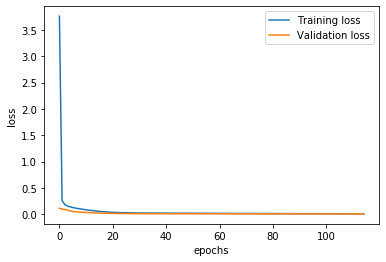

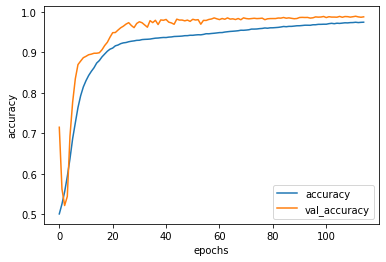

Tuning :leaky_relu_lr1e-4_dropout
* Accuracy on test1 set: 96.03%
* Accuracy on test2 set: 70.20%
* Accuracy on test3 set: 83.57%


In [18]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [19]:
def create_base_network_drop_2(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [20]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [21]:
model_name='leaky_relu_lr1e-4_dropout_after_flat'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 141us/sample - loss: 3.5303 - accuracy: 0.5005 - val_loss: 0.1359 - val_accuracy: 0.7049
Epoch 2/200
60145/60145 [==============================] - 8s 126us/sample - loss: 0.2868 - accuracy: 0.5200 - val_loss: 0.0901 - val_accuracy: 0.7136
Epoch 3/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.1845 - accuracy: 0.5641 - val_loss: 0.0823 - val_accuracy: 0.6454
Epoch 4/200
60145/60145 [==============================] - 8s 126us/sample - loss: 0.1495 - accuracy: 0.6106 - val_loss: 0.0671 - val_accuracy: 0.7507
Epoch 5/200
60145/60145 [==============================] - 8s 126us/sample - loss: 0.1325 - accuracy: 0.6665 - val_loss: 0.0570 - val_accuracy: 0.8279
Epoch 6/200
60145/60145 [==============================] - 8s 126us/sample - loss: 0.1210 - accuracy: 0.7146 - val_loss: 0.0508 - val_accuracy: 0.8604
Epoch 7/200
60145/60145 [====================

Tuning :leaky_relu_lr1e-4_dropout_after_flat


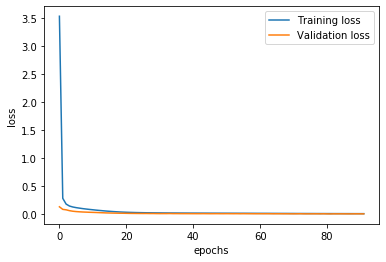

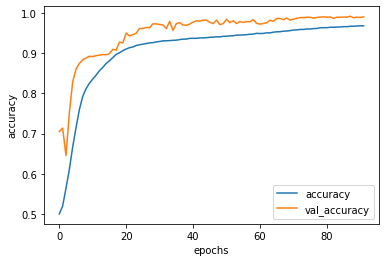

Tuning :leaky_relu_lr1e-4_dropout_after_flat
* Accuracy on test1 set: 96.01%
* Accuracy on test2 set: 69.16%
* Accuracy on test3 set: 83.37%


In [22]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [31]:
def create_base_network_drop_3(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [32]:
select_base_arch=create_base_network_drop_3(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [33]:
model_name='leaky_relu_lr1e-4_dropout_3'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 146us/sample - loss: 9.3354 - accuracy: 0.5000 - val_loss: 0.1280 - val_accuracy: 0.6087
Epoch 2/200
60145/60145 [==============================] - 8s 129us/sample - loss: 1.0472 - accuracy: 0.5000 - val_loss: 0.1183 - val_accuracy: 0.5407
Epoch 3/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.7131 - accuracy: 0.5000 - val_loss: 0.1220 - val_accuracy: 0.5122
Epoch 4/200
60145/60145 [==============================] - 8s 131us/sample - loss: 0.5716 - accuracy: 0.5000 - val_loss: 0.1285 - val_accuracy: 0.5008
Epoch 5/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.4767 - accuracy: 0.5000 - val_loss: 0.1347 - val_accuracy: 0.5000
Epoch 6/200
60145/60145 [==============================] - 8s 134us/sample - loss: 0.4006 - accuracy: 0.5000 - val_loss: 0.1398 - val_accuracy: 0.5010
Epoch 7/200
60145/60145 [====================

Tuning :leaky_relu_lr1e-4_dropout_3


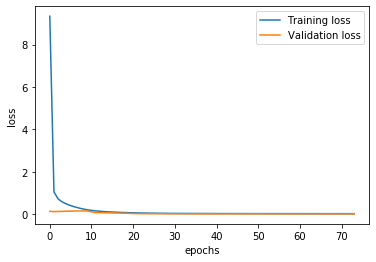

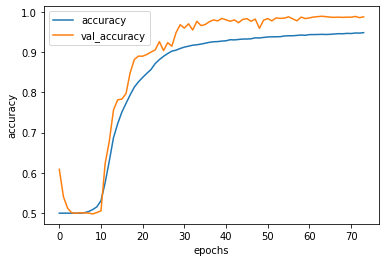

Tuning :leaky_relu_lr1e-4_dropout_3
* Accuracy on test1 set: 95.27%
* Accuracy on test2 set: 70.22%
* Accuracy on test3 set: 83.09%


In [34]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [23]:
#ELU

In [27]:
def create_base_network_elu(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.elu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.elu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [28]:
select_base_arch=create_base_network_elu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [29]:
model_name='ELU_lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 126us/sample - loss: 3.1725 - accuracy: 0.5120 - val_loss: 0.2720 - val_accuracy: 0.5292
Epoch 2/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.1839 - accuracy: 0.6519 - val_loss: 0.1101 - val_accuracy: 0.8105
Epoch 3/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.1008 - accuracy: 0.7869 - val_loss: 0.0664 - val_accuracy: 0.9154
Epoch 4/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0721 - accuracy: 0.8530 - val_loss: 0.0505 - val_accuracy: 0.9289
Epoch 5/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0569 - accuracy: 0.8779 - val_loss: 0.0393 - val_accuracy: 0.9434
Epoch 6/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.0473 - accuracy: 0.8930 - val_loss: 0.0331 - val_accuracy: 0.9495
Epoch 7/200
60145/60145 [====================

Tuning :ELU_lr1e-4


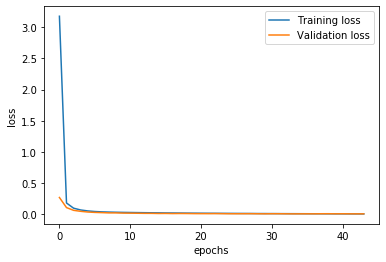

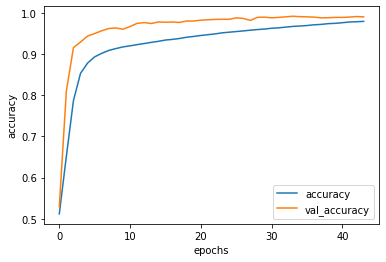

Tuning :ELU_lr1e-4
* Accuracy on test1 set: 96.27%
* Accuracy on test2 set: 69.11%
* Accuracy on test3 set: 83.31%


In [30]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [ ]:
# with margin as 1
Ass2_Equation = equation(1.0)

In [ ]:
model_name='ELU_lr1e-3_dropout_margin1'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])